Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

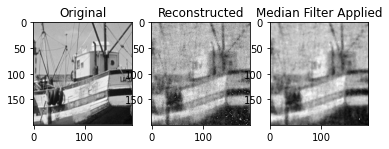

In [4]:
# Fraction to scale the original image
SCALE = 1
# Fraction of the scaled image to randomly sample
SAMPLE = 1 / 6
# Coefficient for the L1 norm of variables (see OWL-QN algorithm)
ORTHANTWISE_C = 8

# File pathsrandom
ORIG_IMAGE_PATH = 'fishing_boat.bmp'

# Set up global variables
_image_dims = None  # track target image dimensions here
_ri_vector = None  # reference the random sampling indices here
_b_vector = None  # reference the sampled vector b here
_A_matrix = None  # reference the dct matrix operator A here


def kron_rows(A, B, I, f=None):
    """Return individual rows of K=kron(A,B) if `f` is None. Otherwise
    save the matrix to file.
    """

    # find row indices of A and B
    global K
    ma, na = A.shape
    mb, nb = B.shape
    R = np.floor(I / mb).astype('int')  # A row indices of interest
    S = np.mod(I, mb)  # B row indices of interest

    # calculate kronecker product rows
    n = na * nb
    if f is None:
        K = np.zeros((I.size, n))

    for j, (r, s) in enumerate(zip(R, S)):
        row = np.multiply(
            np.kron(A[r, :], np.ones((1, nb))),
            np.kron(np.ones((1, na)), B[s, :])
        )
        if f is None:
            K[j, :] = row
        else:
            row.tofile(f)

    if f is None:
        return K

def evaluate(x, g, step):
    """An in-memory evaluation callback.
    """

    # we want to return two things:
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((_image_dims[1], _image_dims[0])).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[_ri_vector].reshape(_b_vector.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - _b_vector
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[_ri_vector] = Axb  # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape)  # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx


def evaluate_kron(x, g, step):
    """An in-memory evaluation callback using the kronecker product.
    """

    # calculate the 2-norm squared of the residual vector
    p = np.dot(_A_matrix, x)
    fx = np.sum(np.power(_b_vector - p, 2))

    # calculate the gradient vector
    atax = np.dot(_A_matrix.T, p)
    atb = np.dot(_A_matrix.T, _b_vector)
    np.copyto(g, 2 * (atax - atb))

    return fx


def main():
    global _b_vector, _A_matrix, _image_dims, _ri_vector, Xat2

    # read image in grayscale, then downscale it
    Xorig = imgRead(ORIG_IMAGE_PATH)
    X = zoom(Xorig, SCALE)
    ny, nx = X.shape[0], X.shape[1]

    # take random samples of image, store them in a vector b
    k = round(np.floor(nx * ny * SAMPLE))
    ri = np.random.choice(nx * ny, k, replace=False)  # random sample of indices
    b = X.T.flat[ri].astype(float)  # important: cast to 64 bit

        # This method computes a dct2 matrix operator A (a kronecker product)
        # and uses it directly to evaluate the objective function. However,
        # as the size of the target image gets bigger, A gets unmanageable.

        # save refs to global vars
        _b_vector = np.expand_dims(b, axis=1)
        _A_matrix = kron_rows(
            idct(np.identity(nx), norm='ortho', axis=0),
            idct(np.identity(ny), norm='ortho', axis=0),
            ri
        )

        # perform the L2 minimization in memory
        Xat2 = owlqn(nx * ny, evaluate_kron, progress, ORTHANTWISE_C)

    # transform the output back into the spatial domain
    Xat = Xat2.reshape(nx, ny).T  # stack columns
    Xa = idct2(Xat)

    # create images of mask (for visualization)
    mask = np.zeros(X.shape)
    mask.T.flat[ri] = 255
    Xm = 255 * np.ones(X.shape)
    Xm.T.flat[ri] = X.T.flat[ri]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    imgOut = np.uint8(Xa)
    imgOut_filtered = median_filter(imgOut, 3)
    ax1.imshow(Xorig, cmap='gray')
    ax1.set_title("Original")
    ax2.imshow(imgOut, cmap='gray')
    ax2.set_title("Reconstructed")
    ax3.imshow(imgOut_filtered, cmap='gray')
    ax3.set_title("Median Filter Applied")
    plt.show()


if __name__ == '__main__':
    main()


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59


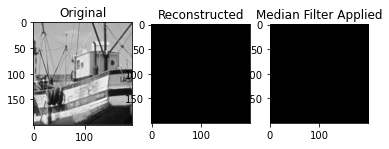

In [3]:
    X = np.random.rand(200,200)